In [1]:
import sys
sys.path.insert(0,'C:/Users/owner/Documents/GitHub/gym-warehouse')

import gym
import gym_warehouse
import numpy as np
import copy

env = gym.make('warehouse-v0')
# env.render()

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html
SHAPE OF CLASS MAP:  (5, 10)


In [2]:
class Robot:

    def __init__(self,location,name):
        self.entrance = location
        self.location = location
        self.name = name
        self.loaded = False
        self.assignment = None
        self.sorted_orders = None
        self.fulfilled = 0
#         self.next_move = (0,0)
        
    def get_closest_orders(self,orders):

        ord_dist=[]
        for i in orders:

            distance = abs(self.location[0] - i.location[0]) + abs(self.location[1] - i.location[1])
            moves = (self.location[0]-i.location[1],self.location[1]-i.location[1])
        
            ord_dist.append([i, distance])
            
        self.sorted_orders = sorted(ord_dist, key=lambda x: x[1])
        
    
    def is_loaded(self,warehouse):
        if self.assignment is not None:
            if self.location == self.assignment.location:
                self.loaded=True
                warehouse.clear_order(self.assignment)
                self.clear_order()
        else:
#             LOOP THROUGH ALL ORDERS TO SEE IF WE ARE ON AN ORDER
            for i in warehouse.orders:
                if i.location == self.location:
                    self.loaded=True
                    warehouse.clear_order(i)
            
            
    def step(self,dir_,warehouse):
        

        
        old_loc = self.location
        self.location = [sum(x) for x in zip(self.location, dir_)]
        
        if self.assignment == None and self.loaded==True:
            if self.location == self.entrance:
                self.loaded = False
                self.fulfilled +=1
            else:
                pass
        elif self.loaded == False:
            self.is_loaded(warehouse)
        
       # print("Robot:  ", self, " old_loc: ", old_loc)
        
              
    def assign(self,order,override=False):
        
        if order == None and override:
            if self.assignment is not None:
                self.assignment.assignment = None
            self.assignment = order
            return True   
        
        elif order.assignment == None:
            
            if self.assignment is not None:
                self.assignment.assignment = None
                
            self.assignment = order
            order.assign(self)    
            return True
        
        elif override:
            if self.assignment is not None:
                self.assignment.assignment = None
                self.assignment = None
            self.assignment = order
            order.assignment.assignment = None
            order.assign(self)
            return True           
        
        elif self.assignment==order:
            return True
        
        return False
        
    
    def get_dist(self,order):
        if order is None:
            return 0
        return abs(self.location[0] - order.location[0]) + abs(self.location[1] - order.location[1])
    
    def get_direction(self,location):
        
        return ((self.location[0] - location[0]) , (self.location[1] - location[1]))
    
    def find_next_move(self):
        
        self.is_loaded(warehouse)
        
        if self.loaded:
            (up,right) = self.get_direction(self.entrance)
        elif self.assignment == None:
            return [0,0]
        else:
            (up,right) = self.get_direction(self.assignment.location)
        
        if up==0:
            temp_up=0
        elif up > 0:
            temp_up = min(max(up,0),-1)
        else:
            temp_up = max(min(up,0),1)
        
        
        if right==0:
            temp_right=0
        elif right > 0:
            temp_right = min(max(right,0),-1)
        else:
            temp_right = max(min(right,0),1)
        
        #print("Robot: ", self ," Get Directions: ",(up,right), " temp_up: ",temp_up," temp_right: ", temp_right)
        
        return [temp_up,temp_right]
    

    
    def __str__(self):
        return f'{self.name} at {self.location}'
        
    def __repr__(self):
        return f'{self.name} at {self.location}'              
        
    def clear_order(self):       
        self.assignment = None

In [3]:
class Order:
    
    def __init__(self,location):
        self.location = location
        self.assignment = None
        
    def assign(self,robot):
        self.assignment = robot
        
    def __str__(self):
        return f'Location of Order is {self.location} and assignment is {self.assignment}'
        
    def __repr__(self):
        return f'Location of Order is {self.location} and assignment is {self.assignment}'


In [4]:
class Warehouse:
    
    def __init__(self,locations):
        self.robot_1_location = locations[0]
        self.robot_2_location = locations[1]
        
        self.robot_1 = Robot(self.robot_1_location,"Robot-1")
        self.robot_2 = Robot(self.robot_2_location,"Robot-2")
        
        self.orders = []
        
    def new_order(self,location):
        order = Order(location)
        self.orders.append(order)
        
    def order_by_closeness(self):
        self.robot_1.get_closest_orders(self.orders)
        self.robot_2.get_closest_orders(self.orders)
        
    def print_orders(self):
        print(self.orders)
        
    def get_cost(self):
        return self.robot_1.get_dist(self.robot_1.assignment) + self.robot_2.get_dist(self.robot_2.assignment)
    
    def check_swap(self):
        
        current_cost = self.get_cost()
        swap_cost = self.robot_1.get_dist(self.robot_2.assignment) + self.robot_2.get_dist(self.robot_1.assignment)
        
        
        if swap_cost < current_cost:
            self.robot_1.assign(self.robot_2.assignment,True)
            self.robot_2.assign(self.robot_1.assignment,True)
#             print("swap occured")
            
#         else:
#             print("NO swap")
            
    def interpret_move(self,dir_,vert):
        if vert == True:
            if dir_==1:
                return 1
            elif dir_== -1:
                return 2
            
        elif vert==False:
            if dir_== 1:
                return 4
            elif dir_==-1:
                return 3
            

    def move_robot(self,robot_a,robot_b,warehouse):
        
        temp = robot_a.find_next_move()
            
        up_move = [temp[0],0]
        right_move = [0,temp[1]]
        
        if [sum(x) for x in zip(robot_a.location, up_move)] == robot_b.location:
            temp[0] = 0 #can't go up
            if temp[1] == 0:
                
                if robot_a.location[1]==0:
                    temp[1] = 1
                elif robot_a.location[1]==4:
                    temp[1] = -1
                else:
                    if np.random.uniform() < 0.5:
                        temp[1] = 1
                    else:
                        temp[1] = -1
                    
        elif [sum(x) for x in zip(robot_a.location, right_move)] == robot_b.location:
            temp[1] = 0 #can't go right  
            if temp[0] == 0:
                
                if robot_a.location[0]==0:
                    temp[0] = 1
                elif robot_a.location[0]==9:
                    temp[0] = -1
                else:
                    if np.random.uniform() < 0.5:
                        temp[0] = 1
                    else:
                        temp[0] = -1
        

        if temp[0]==0:
            robot_a.step([0,temp[1]],warehouse)
            return self.interpret_move(temp[1],vert=False)
        
        elif temp[1]==0:
            robot_a.step([temp[0],0],warehouse)
            return self.interpret_move(temp[0],vert=True)

        else:
            if np.random.uniform() < 0.5:
                robot_a.step([temp[0],0],warehouse)
                return self.interpret_move(temp[0],vert=True)
            else:
                robot_a.step([0,temp[1]],warehouse)
                return self.interpret_move(temp[1],vert=False)

    
    
    def get_order_locations(self):
        return [order.location for order in self.orders]
    
    def clear_order(self,order):
        for i in self.orders:
            if i.location==order.location:
                self.orders.remove(i)
        
    


In [5]:
warehouse = Warehouse([[0,1],[0,3]])

In [6]:
rew1=[]
rew2=[]
cum_rew = [0,0]
distance=[0,0]
no_steps = 10000 #no of secs in an 18 hr day
# no_steps=int(no_steps/2)

%timeit
for s in range(no_steps):

    obs,rew,done,info = env.step([0,0])
    obs=obs.T

    # Every time I take a step, do the following to retrieve new orders
    order_locations = warehouse.get_order_locations()
    for i in range(obs.shape[0]):
        for j in range(obs.shape[1]):
            if [i,j] not in order_locations:
                if obs[i][j] == 1 or obs[i][j] == -2:
                    warehouse.new_order([i,j])

    warehouse.order_by_closeness()
    #env.render()
    #warehouse.print_orders()
        
    if len(warehouse.orders)>0:
        idx_1 = 0
        idx_2 = 0
        # assign robot 1 to closest order
        if warehouse.robot_1.loaded == False:
            assignment_1 = warehouse.robot_1.assign(warehouse.robot_1.sorted_orders[idx_1][0])
            idx_1+=1
            while assignment_1 == False and idx_1<len(warehouse.orders): 
                assignment_1 = warehouse.robot_1.assign(warehouse.robot_1.sorted_orders[idx_1][0])  
                idx_1+=1

        # assign robot 2 to closest order
        if warehouse.robot_2.loaded == False:
            assignment_2 = warehouse.robot_2.assign(warehouse.robot_2.sorted_orders[idx_2][0])
            idx_2+=1
            while assignment_2 == False and idx_2<len(warehouse.orders):
                assignment_2 = warehouse.robot_2.assign(warehouse.robot_2.sorted_orders[idx_2][0])  
                idx_2+=1

#         swap
        if len(warehouse.orders)>0:
            warehouse.check_swap()

    r1_move = 0
    r2_move = 0
#     print("MOVES: ",[r1_move,r2_move])
#     warehouse.print_orders()
    
#     print("Move condition: ",warehouse.robot_1.loaded ==True or warehouse.robot_1.assignment is not None)
#     print("Condition 1: ",warehouse.robot_1.loaded ==True)
#     print("Condition 2: ",warehouse.robot_1.assignment is not None)

    #move the robot
    if warehouse.robot_1.loaded == True or warehouse.robot_1.assignment is not None:
        r1_move = warehouse.move_robot(warehouse.robot_1,warehouse.robot_2,warehouse)
    if warehouse.robot_2.loaded == True or warehouse.robot_2.assignment is not None:
        r2_move = warehouse.move_robot(warehouse.robot_2,warehouse.robot_1,warehouse)
        
#     print("Move condition: ",warehouse.robot_1.loaded ==True or warehouse.robot_1.assignment is not None)
#     print("Condition 1: ",warehouse.robot_1.loaded ==True)
#     print("Condition 2: ",warehouse.robot_1.assignment is not None)
        
#     print("MOVES: ",[r1_move,r2_move])

   
    rew=[0,0]    
    obs,rew,done,info = env.step([r1_move,r2_move])
    
    distance[0]+=info[0]
    distance[1]+=info[1]
    

    
#     if s%10 == 0:
#         env.render()
    
    cum_rew[0] = cum_rew[0] + rew[0]
    cum_rew[1] = cum_rew[1] + rew[1]
    rew1.append(rew[0])
    rew2.append(rew[1])
    

In [7]:
distance

[14882529, 11968742]

In [8]:
abs(distance[0]-distance[1])

2913787

In [9]:
sum(distance)

26851271

In [ ]:
warehouse.robot_1.sorted_orders

In [ ]:
warehouse.robot_1.loaded 

In [ ]:
==True or warehouse.robot_1.assignment is not None

In [ ]:
env.render()

In [10]:
print("reward: ", cum_rew)
total_orders = len(warehouse.orders) + warehouse.robot_1.fulfilled + warehouse.robot_2.fulfilled
print("total_orders: ", total_orders, "orders1: ", warehouse.robot_1.fulfilled, "orders2: ", warehouse.robot_2.fulfilled)

reward:  [-2079904, -2573117]
total_orders:  471 orders1:  294 orders2:  177


In [11]:
import matplotlib.pyplot as plt

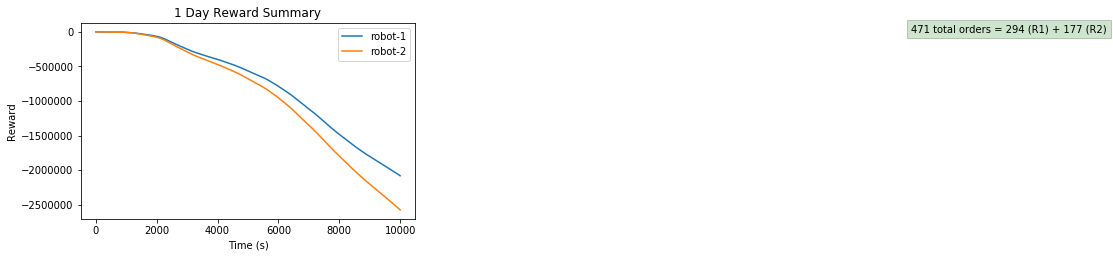

In [12]:
caption = "{} total orders = {} (R1) + {} (R2)".format(total_orders,warehouse.robot_1.fulfilled,warehouse.robot_2.fulfilled)

plt.title("1 Day Reward Summary")
plt.plot(np.cumsum(rew1),label="robot-1")
plt.plot(np.cumsum(rew2),label="robot-2")
plt.ylabel("Reward")
plt.xlabel("Time (s)")
plt.legend()
plt.text(30000, -1000, caption, horizontalalignment='center', bbox=dict(facecolor='g', alpha=0.2))
plt.gcf().subplots_adjust(bottom=0.2)
# plt.savefig('no_swap_day3.png')
plt.savefig('swap_day1.png')
plt.show()

In [ ]:
len(rew1)

In [ ]:
print(warehouse.robot_1.location)
print(warehouse.robot_1.assignment)
print(warehouse.robot_1.loaded)

In [ ]:
print(warehouse.robot_2.location)
print(warehouse.robot_2.assignment)
print(warehouse.robot_2.loaded)

In [ ]:
warehouse.robot_1.entrance

In [ ]:
warehouse.robot_1.location

In [ ]:
warehouse.robot_2.location